# Choosing and Training a Model

In this notebook I will focus in on the Random Forest classifier with all 6 classes in my target category.

Target: issue_reported(y)



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

Import data of clean features

In [2]:
file = '/Users/tshields/Documents/GitHub/Real-Time_Traffic_Incident_Reports/FeatureEngineering/feature_engineering4.csv'

In [3]:
df = pd.read_csv(file, index_col=0)
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180


In [4]:
df.describe()

,Latitude,Longitude,issue_timespan,hour,dist_cntr_km
count,243114.000000,243114.000000,243114.000000,243114.000000,243114.000000
mean,30.301716,-97.733273,72.641459,13.659287,11.826093
std,0.093666,0.086736,90.826579,7.055001,7.320069
min,30.004413,-98.226709,0.333333,0.000000,0.007638
25%,30.232036,-97.776903,20.766667,9.000000,6.040102
50%,30.294241,-97.734390,41.316667,15.000000,10.961410
75%,30.373598,-97.687501,81.166667,19.000000,16.959760
max,30.798642,-97.293320,480.000000,23.000000,60.669983


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243114 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  243114 non-null  object 
 1   issue_reported  243114 non-null  object 
 2   Latitude        243114 non-null  float64
 3   Longitude       243114 non-null  float64
 4   issue_timespan  243114 non-null  float64
 5   geometry        243114 non-null  object 
 6   day             243114 non-null  object 
 7   hour            243114 non-null  int64  
 8   month           243114 non-null  object 
 9   region          243114 non-null  object 
 10  quadrant        243114 non-null  object 
 11  dist_cntr_km    243114 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 24.1+ MB


In [6]:
df['issue_reported'].unique()

array(['Crash Service', 'Traffic Hazard', 'Collision', 'Stalled Vehicle',
       'Loose Livestock', 'Traffic Impediment'], dtype=object)

#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [7]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
1,2018-06-13 10:15:36+00:00,4,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
3,2020-04-17 21:40:52+00:00,4,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243114 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  243114 non-null  object 
 1   issue_reported  243114 non-null  int64  
 2   Latitude        243114 non-null  float64
 3   Longitude       243114 non-null  float64
 4   issue_timespan  243114 non-null  float64
 5   geometry        243114 non-null  object 
 6   day             243114 non-null  object 
 7   hour            243114 non-null  int64  
 8   month           243114 non-null  object 
 9   region          243114 non-null  object 
 10  quadrant        243114 non-null  object 
 11  dist_cntr_km    243114 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 24.1+ MB


In [9]:
df['issue_reported'].unique()

array([1, 4, 0, 3, 2, 5])

In [10]:
df['issue_reported'].value_counts()

1    93808
4    93012
0    32536
3    11965
2     5914
5     5879
Name: issue_reported, dtype: int64

## Scaling Timespan and Latitude/Longitude Features
First, create a series variable using .values

In [11]:
series1 = df.issue_timespan.values
series2 = df.dist_cntr_km.values

Then reshape the series to scale it as 2D arrays

In [12]:
series1 = series1.reshape(-1,1)

In [13]:
series2 = series2.reshape(-1,1)

In [14]:
scaler = StandardScaler()

Then create new columns for for each of the series.

In [15]:
df['scaled_timespan'] = scaler.fit_transform(series1)

In [16]:
df['scaled_dist_km'] = scaler.fit_transform(series2)

In [17]:

df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km,scaled_timespan,scaled_dist_km
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061,0.786393,-1.362973
1,2018-06-13 10:15:36+00:00,4,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002,-0.090188,-0.384846
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301,-0.469483,0.054946
3,2020-04-17 21:40:52+00:00,4,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232,-0.643625,-0.610496
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180,0.842360,-0.158594


## One Hot Encoding

In [18]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region', 'quadrant'])

In [19]:
dummies = dummies.drop(columns=['issue_reported', 'issue_timespan', 'Latitude','Longitude', 'geometry', 
                                'published_date', 'dist_cntr_km'])

In [20]:
dummies.head()

,scaled_timespan,scaled_dist_km,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,...,region_vce,region_vcw,region_vne,region_vnw,region_vse,region_vsw,quadrant_ne,quadrant_nw,quadrant_se,quadrant_sw
0,0.786393,-1.362973,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.090188,-0.384846,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,-0.469483,0.054946,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,-0.643625,-0.610496,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.842360,-0.158594,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [21]:
X = dummies

In [22]:

y = df.issue_reported

In [23]:
X.shape

(243114, 61)

In [24]:
y.shape

(243114,)

## Train Test Split and Scale

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [26]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest Accuracy and F1 Scores

In [32]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))

Random Forest: Accuracy=0.571
Random Forest: f1-score=0.551
Random Forest: Balanced Accuracy=0.343


## Random Forest Hyperparamter Tuning


The Random Forest default performed best. Now to find the best parameters to tune.

In [33]:
forest = RandomForestClassifier()

In [34]:
n_estimators = [120, 300, 500, 800]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]


hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             )

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [35]:
print('Best n_estimators:', bestF.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', bestF.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', bestF.best_estimator_.get_params()['min_samples_split'])

Best n_estimators: 500
Best max_depth: 25
Best min_samples_split: 15


In [31]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 500, min_samples_split = 15)
                                   
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

## A confusion matrix on Random Forest model

In [131]:
class_names=['Crash Service', 'Traffic Hazard', 'Stalled Vehicle', 'Collision', 'Loose Livestock', 
             'Traffic Impediment'] # name  of classes

Confusion matrix, without normalization
[[ 5777   950   106     0  2930     0]
 [  601 19092     3     0  8615     0]
 [  980    76   197     0   531     0]
 [  133   991     1     1  2410     0]
 [ 2204  7560    93     1 17904     0]
 [   23   872     0     0   884     0]]
Normalized confusion matrix
[[5.92e-01 9.73e-02 1.09e-02 0.00e+00 3.00e-01 0.00e+00]
 [2.12e-02 6.74e-01 1.06e-04 0.00e+00 3.04e-01 0.00e+00]
 [5.49e-01 4.26e-02 1.10e-01 0.00e+00 2.98e-01 0.00e+00]
 [3.76e-02 2.80e-01 2.83e-04 2.83e-04 6.82e-01 0.00e+00]
 [7.94e-02 2.72e-01 3.35e-03 3.60e-05 6.45e-01 0.00e+00]
 [1.29e-02 4.90e-01 0.00e+00 0.00e+00 4.97e-01 0.00e+00]]


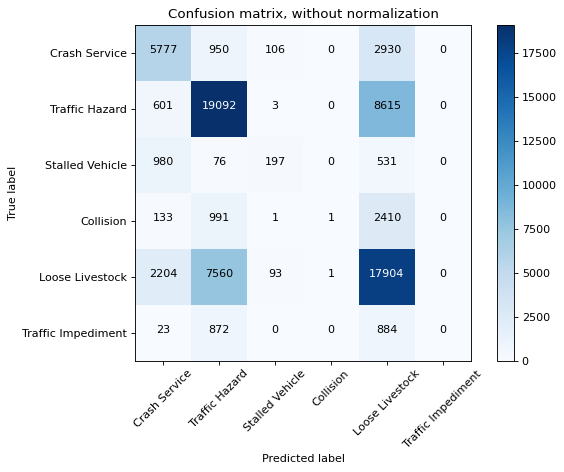

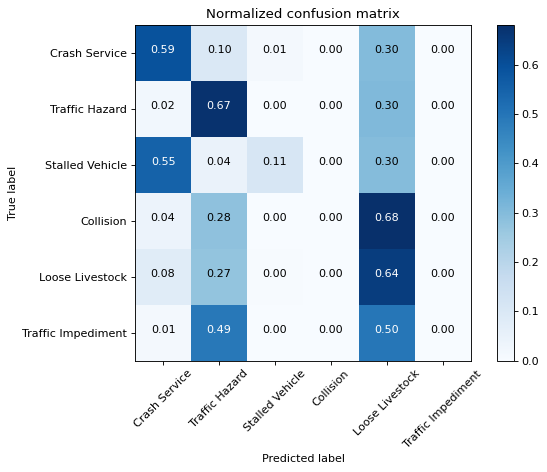

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

There appears to be 3 classes in particular that stand out:

Crash Service

Traffic Hazard

Loose Livestock

# What were the most important variables?

30


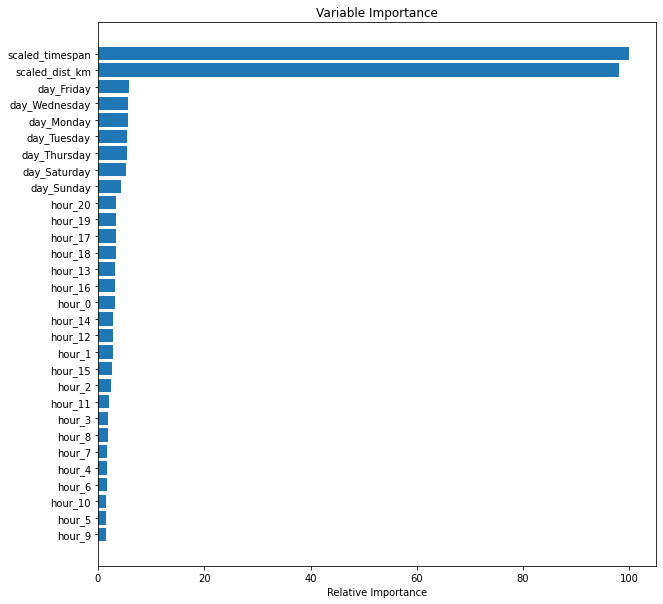

In [133]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [134]:
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
43,1,1
146776,1,1
96622,4,1
87263,0,4
112654,1,1
...,...,...
117431,0,4
238726,1,4
49844,5,1
152669,4,4


# Running Reports

In [136]:
from sklearn.metrics import mean_squared_error
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))


Random Forest: Accuracy=0.571
Random Forest: f1-score=0.563
Random Forest: Balanced Accuracy=0.337
